In [2]:
%matplotlib inline
from analysis_utils import display_wrapper, organize_tif, plot_onset_index, rotate_crop_array
from analysis_utils import cal_velocity
from glob import glob
from os.path import join as pjoin
from pprint import pprint
from scipy.ndimage import rotate
from tifffile import imread, imwrite, TiffFile
from tqdm import tqdm
from wf_utils import filename2int, log_progress
from wfield.io import frames_average_for_trials, mmap_dat, TiffStack
from wfield import approximate_svd

import cv2, os, shutil, subprocess, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Parameter setting

In [4]:
plot_test = True
# Set the file path
root_path = '/home/wrx/Data_WF/WF_WRX/'
mice_id = 'Q39'
treat = '20240829_saline'
path_0 = pjoin(root_path, mice_id, treat)
# path_0 = '/home/wrx/Data_WF/WF_VC_liuzhaoxi/24.07.18_P73'
print(path_0)

path_1_ = os.listdir(path_0)
# 筛选出文件夹
path_1 = [folder for folder in path_1_ if os.path.isdir(pjoin(path_0, folder))]
path_all = []
for path in path_1:
    path_all.append(pjoin(path_0, path))

print('All the file path:\n')
pprint(path_all)

/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline
All the file path:

['/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/1_Spontaneous',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/3_Movingbar',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/4_SalienceGrating',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/5_SalienceMovingGrating',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/6_Looming',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/7_NatureMovie']


Re-organize files

In [4]:
# only run this cell once
for path in path_all:
    if not os.path.exists(pjoin(path, 'raw')):
        os.mkdir(pjoin(path, 'raw'))
    if not os.path.exists(pjoin(path, 'process/')):
        os.mkdir(pjoin(path, 'process/'))
        
for path in path_all:
    files = glob(pjoin(path, '202?????-??????*'))
    for file in files:
        shutil.move(file, pjoin(path, 'raw', os.path.basename(file)))
        print('moving',file)

print('Moving raw data folders all finished!')


Moving raw data folders all finished!


Set the crop and rotate parameters

In [ ]:
# use this to check wheather the images need rotation and the suitable angle,
# and the coordinates of ROI to crop the raw images

# select the first tif image of 470nm channel of the first experiment as the reference image
image_ref = imread(glob(pjoin(path_all[0], 'raw/*-470/1.tif'))[0])

# rotate iamge by pre-defined angle using scipy.ndimage.rotate
# rotate the images is time-consuming, so we skip rotate the images by setting angle=0
angle = 0 # if clockwise, use negative angle, otherwise positive
left, top, width, height = 38, 65, 450, 380
cropped_image = rotate_crop_array(image_ref, angle=angle, left=left, top=top, width=width, height=height)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(image_ref, cmap='hot', aspect='equal')
axs[0].set_title('original image')
axs[0].grid()
axs[1].imshow(cropped_image, cmap='hot', aspect='equal')
axs[1].set_title('cropped image')
axs[1].grid()
plt.show()

In [ ]:
### generate 2-channel tif stack

for path in [path_all[1]]:
    print("Path: "+ path)
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    stim_name = path.split('/')[-1]
    # 列出experiments
    items = glob(pjoin(rawPath, '202?????-??????-4*'))
    experiments = list(set([os.path.basename(item)[:15] for item in items]))
    print("experiments:")
    print(experiments)
    
    # 遍历每个experiment，merge channel
    for experiment in experiments:
        os.makedirs(pjoin(processPath, experiment+"-wfield"), exist_ok=True)
        mergePath = pjoin(processPath, experiment+"-wfield")
        merge_file = pjoin(mergePath, experiment+"-merged.tif")
        if not os.path.exists(merge_file):
            tif_405 = organize_tif(pjoin(rawPath, experiment + "-405"), save_path=processPath)
            tif_405 = rotate_crop_array(tif_405, angle=angle, left=left, top=top, width=width, height=height)
            tif_470 = organize_tif(pjoin(rawPath, experiment + "-470"), save_path=processPath)
            tif_470 = rotate_crop_array(tif_470, angle=angle, left=left, top=top, width=width, height=height)
            # tif_405_path = pjoin(mergePath, experiment + "-405.tif")
            # tif_470_path = pjoin(mergePath, experiment + "-470.tif")
            # 检查两个通道的深度是否一致
            if tif_405.shape[0] != tif_470.shape[0]:
                n_frames = min(tif_405.shape[0], tif_470.shape[0])
                tif_405 = tif_405[:n_frames]
                tif_470 = tif_470[:n_frames]
            # 将Tiff stack的数据从三维变成四维，不同通道使用第二维区分
            merged_tif = np.concatenate((tif_470[:, np.newaxis], tif_405[:, np.newaxis]), axis=1)
            # 将合并后的图像保存为一个2通道Tiff图像
            print("saving merged tif of "+ experiment)
            imwrite(merge_file, merged_tif, imagej=True, bigtiff=True)
        # imwrite(tif_405_path, tif_405)
        # imwrite(tif_470_path, tif_470)
                        
        # else: print("merged "+experiment+" has existed")
        # plotFluor(path, experiment)
        
    mean_values_405 = pjoin(path, "process", '{}-405-Values.csv'.format(experiment))
    mean_values_470 = pjoin(path, "process", '{}-470-Values.csv'.format(experiment))
    # read data from csv file as numpy array
    mean_values_405 = np.loadtxt(mean_values_405, delimiter=',')
    mean_values_470 = np.loadtxt(mean_values_470, delimiter=',')

    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(mean_values_405, label='405')
    ax.plot(mean_values_470, label='470')
    ax.legend()
    plt.title(stim_name)
    plt.show()
    
# print("All merging finished!")

In [ ]:
# images to movie for hehavioral data
path = path_all[1]
rawPath = pjoin(path, "raw")
processPath = pjoin(path, "process")
items = glob(pjoin(rawPath, '202?????-??????-4*'))
experiment = list(set([os.path.basename(item)[:15] for item in items]))
print("experiments:", experiment)
mergePath = pjoin(processPath, experiment[0]+"-wfield")
event_file = pjoin(mergePath, experiment[0]+"-event.tif")
print("event file:", event_file)
if not os.path.exists(event_file):
    tif_event = organize_tif(pjoin(rawPath, experiment[0] + "-event"))
    # imwrite(event_file, tif_event)

Onset and offset detection

In [5]:
path_wfield_all = glob(pjoin(path_0, '*/process/*-wfield'))
pprint(path_wfield_all)

['/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/1_Spontaneous/process/20240829-160641-wfield',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy/process/20240829-163749-wfield',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/3_Movingbar/process/20240829-165104-wfield',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/4_SalienceGrating/process/20240829-165723-wfield',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/5_SalienceMovingGrating/process/20240829-170313-wfield',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/6_Looming/process/20240829-171746-wfield',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/7_NatureMovie/process/20240829-172407-wfield']


In [ ]:
# to generate the trials.csv and trial_onsets.npy for the wfield software

n_movie_rep = 5
frame_rate = 10 # Hz

velocity_ls = []

for path_wfield in [path_wfield_all[1]]:
    stim_name = path_wfield.split('/')[-3]
    experiment = os.path.basename(path_wfield)[:15]
    rawPath = pjoin(path_wfield,'../../raw')
    merge_file = pjoin(path_wfield, experiment+"-merged.tif")
    # n_frames = len(TiffFile(merge_file).pages)//2

    # generate trial_onsets.npy
    # trial_onsets.npy is a Nx4 array.
    csv_path = pjoin(path_wfield, 'trials.csv')
    print(csv_path)

    even_data = pd.read_csv(pjoin(rawPath, experiment + ".csv"), header=None).values
    n_tif = len(os.listdir(glob(pjoin(rawPath, '*-470'))[0]))
    event_frame_rate = np.round(len(even_data) / n_tif).astype(int)
    onset_frame_index = np.round((np.where(np.diff(even_data[:, 0]) == 1)[0] + 1) / event_frame_rate).astype(int)
    offset_frame_index = np.round((np.where(np.diff(even_data[:, 0]) == -1)[0] + 1) / event_frame_rate).astype(int)

    # Calculate the velocity of the encoder, only for event_frame_rate=100
    if event_frame_rate == 100:
        velocity = cal_velocity(even_data)
        velocity_ls.append(velocity)

    # the interval between two onsets less than 1s may be false onset
    false_onset = np.where(np.diff(onset_frame_index) < 10)[0] + 1
    onset_frame_index = np.delete(onset_frame_index, false_onset) # delete the false onset
    offset_frame_index = np.delete(offset_frame_index, false_onset)

    if 'SalienceGrating' in stim_name or 'SalienceMovingGrating' in stim_name:
        # For those two stimulus, the first onset of the stimlus in this list should ignore,
        # because the first onset without stimuli, just the start of the experiment
        onset_frame_index = onset_frame_index[1:]
        offset_frame_index = offset_frame_index[1:]

    plot_onset_index(onset_frame_index, title=stim_name) # to check the onset of the trials
    # stim_delay = pd.read_csv(pjoin(rawPath, experiment + "-470Timestamp.csv"), header=None).values
    # stim_delay = int(stim_delay[0]/10)
    
    # stim = np.zeros(n_frames)
    # for i in range(n_frames):
    #     stim[i] = stimfile[(i * 10 + stim_delay), 0]
    # single_0_indices = np.where((np.diff(np.append(stim, 0)) == 1) & (np.diff(stim, prepend=0) == -1))[0]
    # single_1_indices = np.where((np.diff(np.append(stim, 0)) == -1) & (np.diff(stim, prepend=0) == 1))[0]
    # # stim[single_1_indices] = 0
    # # stim[single_0_indices] = 1
    
    if np.diff(onset_frame_index).min() < 10: # the minimum interval between two onsets is less than 10 frames
        raise ValueError("The minimum interval between two onsets is less than 1s, please check the stim-file)")
    
    trials_csv = np.stack((np.arange(len(onset_frame_index)), onset_frame_index, offset_frame_index, 
                        offset_frame_index-onset_frame_index), axis=1)  # 这个用来自己检查一下以及自己后续分析
    # np.savetxt(pjoin(path_wfield, "trials.csv"), trials_csv, delimiter=",")
    print("generate trials.csv of "+experiment)
    
    # if 'Retinotopy' in path_wfield:
    #     trial_onsets = np.stack((np.arange(len(onset_frame_index)), onset_frame_index-30, offset_frame_index), axis=1)  # 这个文件给wfield软件做SVD用
    #     # np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)
    
    # elif 'natural-movie' in path_wfield:
    #     n_movie = len(onset_frame_index)//n_movie_rep
    #     trial_onsets = np.empty((n_movie,3))
    #     for i in range(n_movie):
    #         trial_onsets[i] = [i, onset_frame_index[i*n_movie_rep]-100, offset_frame_index[i*n_movie_rep]]
        # np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)   # 这个文件给wfield软件做SVD用
    # elif 'speed' in path_wfield:
    #     trial_onsets = [0, onset_frame_index[0] - 100, offset_frame_index[0]]
    #     np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)   # 这个文件给wfield软件做SVD用
            
print("\nAll generation of trials-file finished!")

In [ ]:
if 'trials_csv' not in locals():
    trials_csv = np.loadtxt(pjoin(path_wfield, 'trials.csv'), delimiter=',')
# if 'trial_onsets' not in locals():
#     trial_onsets = np.load(pjoin(path_wfield, 'trial_onsets.npy'))

Calculate the velocity of the encoder

In [ ]:
speed = {'measure_interval': measure_interval, 'velocity': velocity}
results = {'RT': speed}

from inout_utils import h5py_write
results_path = pjoin(path_0, 'results.hdf5')
print(results_path)
h5py_write(results_path, results)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3))
x = np.arange(0, len(velocity), measure_interval*0.001)
print(x.shape, len(velocity))
ax.plot(x, velocity)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Speed (cm/s)')
plt.title('Speed of the locomotion')
plt.show()

Create binary file

In [ ]:
path_wfield_all

In [ ]:
for path in [path_wfield_all[1]]:
    tif_stack = TiffStack(path, nchannels=2) # set nchannels=1 for our 2 channel tif file
    print('The frames of the stack:', tif_stack.shape[0])
    if tif_stack.shape[0] == 0:
        raise ValueError('The shape of the stack may be wrong!')
    tif_stack.export_binary(foldername=path, basename='{}'.format(tif_stack.shape[0]))

Check and correct outliers

In [6]:
from analysis_utils import correct_lum_outliers
from analysis_utils import detect_dim_outliers

Path: /home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/7_NatureMovie
experiments: ['20240829-172407']


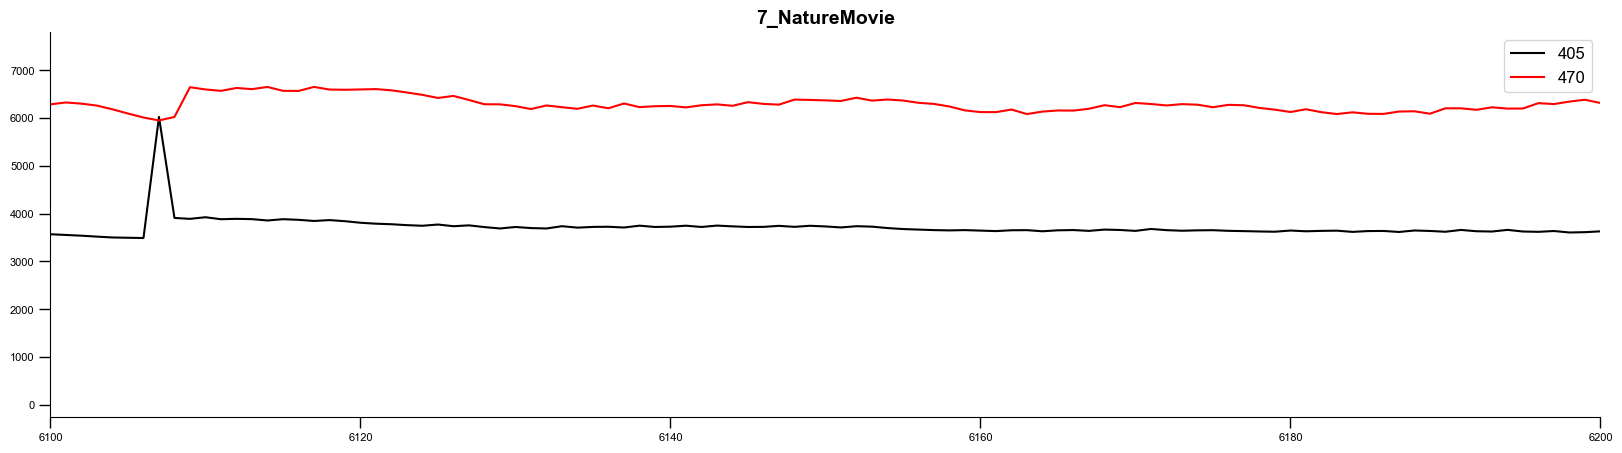

Outliers detected!


In [37]:
# detect outliers based on the mean values of 405 and 470 channels,
# and correct the outliers by averaging the values of the previous and next frames

for path in [path_all[-1]]:
    stim_name = os.path.split(path)[-1]
    print("Path: "+ path)
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    
    items = glob(pjoin(rawPath, '202?????-??????-4*'))
    experiments = list(set([os.path.basename(item)[:15] for item in items]))
    print("experiments:", experiments)
    
    for experiment in experiments:

        values_405_path = pjoin(path, "process", '{}-405-Values.csv'.format(experiment))
        values_470_path = pjoin(path, "process", '{}-470-Values.csv'.format(experiment))
        # read data from csv file as numpy array
        mean_values_405 = np.loadtxt(values_405_path, delimiter=',')
        mean_values_470 = np.loadtxt(values_470_path, delimiter=',')
        n_frames = min(mean_values_405.shape[0], mean_values_470.shape[0])
        mean_values_405 = mean_values_405[:n_frames]
        mean_values_470 = mean_values_470[:n_frames]

        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(mean_values_405, label='405', color='k')
        ax.plot(mean_values_470, label='470', color='r')
        ax.set_xlim(0, len(mean_values_405))
        ax.set_xlim(6100, 6200)
        # ax.set_ylim(2000, 4000)
        # print(outlier_index[1])
        # for idx in outlier_index[1]:
        #     ax.axvline(x=idx, color='r', linestyle='--')
        ax.legend()
        plt.title(stim_name)
        plt.show()

        mean_values = np.concatenate((np.expand_dims(mean_values_470, axis=1), np.expand_dims(mean_values_405, axis=1)), axis=1)
        outlier_index_470, outlier_index_405 = detect_dim_outliers(mean_values, lum_thr_coef=0.3, plot=False)

        if len(outlier_index_470) > 0 or len(outlier_index_405) > 0:
            print("Outliers detected!")
            bin_path = glob(pjoin(processPath, experiment+"-wfield", '*uint16.bin'))[0]
            # correct_lum_outliers(bin_path, outlier_index_470, outlier_index_405, plot=False)

In [20]:
path = path_all[-1]
print(path)

# mean_values = np.concatenate((mean_values_470[:, np.newaxis], mean_values_405[:, np.newaxis]), axis=1)
time_stamp_405 = np.loadtxt(glob(pjoin(path, "raw", '*-405Timestamp.csv'))[0], delimiter=',')
time_stamp_470 = np.loadtxt(glob(pjoin(path, "raw", '*-470Timestamp.csv'))[0], delimiter=',')

if not len(time_stamp_405) == len(time_stamp_470):
    _len = min(len(time_stamp_405), len(time_stamp_470))
    time_stamp_405 = time_stamp_405[:_len]
    time_stamp_470 = time_stamp_470[:_len]

/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/7_NatureMovie


In [21]:
def detect_time_outlier(time_stamp_470, time_stamp_405, time_thr=10):
    '''
    detect the cross-channel outliers based on the time stamps of 405 and 470 channels
    cross-channel: the 405 or 470 channel frames wrongly recoreded.
    
    '''
    diff_time = abs(time_stamp_470 - time_stamp_405)
    time_outliers_idx_470 = np.where(diff_time < (50-time_thr))[0]
    time_outliers_idx_405 = np.where(diff_time > (50+time_thr))[0] + 1

    if time_stamp_470[0] > time_stamp_405[0]: # 470 channel starts first
        return time_outliers_idx_470, time_outliers_idx_405
    else: # 405 channel starts first
        return time_outliers_idx_405, time_outliers_idx_470

outlier_index = detect_time_outlier(time_stamp_470, time_stamp_405)
print(outlier_index)

(array([6108]), array([], dtype=int64))


In [38]:
diff_time = time_stamp_470 - time_stamp_405
print(diff_time[0])

-50.0


In [34]:
def correct_cross_outliers(bin_path, outlier_index_470, outlier_index_405):
    '''
    Correct the outliers frames in the merged tiff file.
    Parameters:
        bin_path: string, the path of the bin file.
        outlier_index_405: numpy array, the index of the outliers in 405 channel.
        outlier_index_470: numpy array, the index of the outliers in 470 channel.
    '''

    if (outlier_index_470 is not None) or (outlier_index_405 is not None):
        print('There are outliers frames need to be corrected!')
        bin_name = os.path.splitext(os.path.basename(bin_path))[0]
        dtype = bin_name.split('_')[-1]
        shape = tuple([int(i) for i in bin_name.split('_')[:-1]])
        images = np.memmap(bin_path, dtype=dtype, mode='r+', shape=shape)
        if outlier_index_470 is not None:
            for i in range(outlier_index_470.shape[0]):
                start, end = outlier_index_470[i], outlier_index_470[i] +1
                images[start:end, 0, :, :] = (images[start-1, 0, :, :] + images[end, 0, :, :]) / 2
        if outlier_index_405 is not None:
            for i in range(outlier_index_405.shape[0]):
                start, end = outlier_index_405[i], outlier_index_405[i] +1
                images[start:end, 0, :, :] = (images[start-1, 0, :, :] + images[end, 0, :, :]) / 2 # in this case, 470 channel also need to be corrected
                images[start:end, 1, :, :] = (images[start-1, 1, :, :] + images[end, 1, :, :]) / 2
        images.flush()
        print('Outliers frames corrected!')
    else:
        print('No outliers frames to correct!')

    return images

In [32]:
bin_path = glob(pjoin(processPath, experiment+"-wfield", '*uint16.bin'))[0]
print(bin_path)

/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/7_NatureMovie/process/20240829-172407-wfield/17605_2_380_450_uint16.bin


Outliers detected!
There are outliers frames need to be corrected!
Outliers frames corrected!


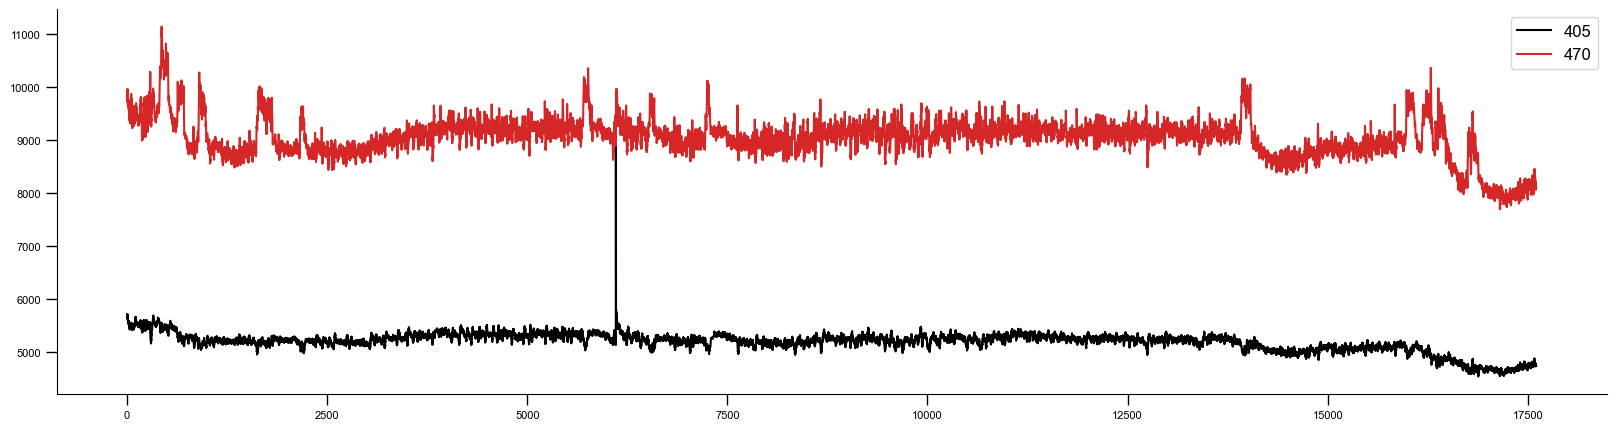

In [35]:
if outlier_index[0].size == 0 and outlier_index[1].size == 0:
    print('No outliers detected!')
    dat = mmap_dat(bin_path)
else:
    print('Outliers detected!')
    dat = correct_cross_outliers(bin_path, outlier_index_470=outlier_index[0], outlier_index_405=outlier_index[1])

    if plot_test:
    # to check the mean values of every frame of 470 and 405 channel
        mean_470 = np.mean(dat[:, 0, :, :], axis=(1, 2))
        mean_405 = np.mean(dat[:, 1, :, :], axis=(1, 2))
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(mean_405, label='405')
        ax.plot(mean_470, label='470')
        plt.legend()
        plt.show()


In [ ]:
start_idx = 500
end_idx = 1000
concat_dat = np.concatenate((dat[start_idx:end_idx, 0, :, :], dat[start_idx:end_idx, 1, :, :]), axis=2)

In [ ]:
display_wrapper(concat_dat, cmap='gray', figsize=(15, 7.5))

In [ ]:
# save the concatenated data as tiff file
tif_path = pjoin(path_wfield_all[0], 'concatenated.tif')
print('saving concatenated tif file:', tif_path)
imwrite(tif_path, concat_dat)

In [ ]:
# if the raw data with no motion, motion_correction may cause 
from wfield.ncaas import load_and_motion_correct
dat_motion_corr = load_and_motion_correct(bin_file)

In [ ]:
from wfield.viz import nb_play_movie

In [ ]:
display_wrapper(dat_motion_corr[:,1,:,:])

Computes baseline

In [ ]:
path = path_wfield_all[1]
print(path)
dat = mmap_dat(glob(pjoin(path, '*uint16.bin'))[0])
print(dat.shape)

In [ ]:
# compare the spontaneous activity of selected frames before and after the stimulus

dat_pre = dat[:3000, 0, :, :]
dat_post = dat[-3000:, 0, :, :]
print(dat_pre.shape, dat_post.shape)
dat_pre_std = np.std(dat_pre, axis=0)
print(dat_pre_std.shape)
dat_post_std = np.std(dat_post, axis=0)
print(dat_post_std.shape)
dat_post1 = dat[3000:6000, 0, :, :]
dat_post2 = dat[6000:9000, 0, :, :]
dat_post1_std = np.std(dat_post1, axis=0)
dat_post2_std = np.std(dat_post2, axis=0)

dat_post1 = dat[3000:6000, 0, :, :]
dat_post2 = dat[6000:9000, 0, :, :]
dat_post1_std = np.std(dat_post1, axis=0)
dat_post2_std = np.std(dat_post2, axis=0)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# vmin = min(dat_pre_std.min(), dat_post_std.min(), dat_post1_std.min(), dat_post2_std.min())
# vmax = max(dat_pre_std.max(), dat_post_std.max(), dat_post1_std.max(), dat_post2_std.max())

vmin = min(dat_pre_std.min(), dat_post_std.min(), dat_post2_std.min())
vmax = max(dat_pre_std.max(), dat_post_std.max(), dat_post2_std.max())

cb = axs[0, 0].imshow(dat_pre_std, cmap='hot', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('std of pre (0-3000)')
axs[0, 0].grid()
fig.colorbar(cb, ax=axs[0, 0], shrink=0.5)

cb = axs[0, 1].imshow(dat_post1_std, cmap='hot', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('std of 3000-6000')
axs[0, 1].grid()
fig.colorbar(cb, ax=axs[0, 1], shrink=0.5)

cb = axs[1, 0].imshow(dat_post2_std, cmap='hot', vmin=vmin, vmax=vmax)
axs[1, 0].set_title('std of 6000-9000')
axs[1, 0].grid()
fig.colorbar(cb, ax=axs[1, 0], shrink=0.5)

cb = axs[1, 1].imshow(dat_post_std, cmap='hot', vmin=vmin, vmax=vmax)
axs[1, 1].set_title('std of post (-3000:)')
axs[1, 1].grid()
fig.colorbar(cb, ax=axs[1, 1], shrink=0.5)
plt.show()

In [ ]:
# # compare the image_base_min and frames_average.npy
# frames_average = np.load(pjoin(path, 'frames_average - 副本.npy'))

# fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
# cb = axs[0].imshow(image_base_min[0], cmap='hot', aspect='equal')
# axs[0].set_title('image_base_min')
# axs[0].grid()
# fig.colorbar(cb, ax=axs[0], shrink=0.5)
# cb = axs[1].imshow(frames_average[0] - image_base_min[0], cmap='hot', aspect='equal')
# axs[1].set_title('frames_average')
# axs[1].grid()
# fig.colorbar(cb, ax=axs[1], shrink=0.5)
# plt.show()

In [ ]:
path = [path for path in path_wfield_all if 'Retinotopy' in path][0]
print(path)
trials_csv = np.loadtxt(pjoin(path, 'trials.csv'), delimiter=',')
print(trials_csv.shape)
# trial_onsets = np.load(pjoin(path, 'trial_onsets.npy'))
dat = mmap_dat(glob(pjoin(path, '*uint16.bin'))[0])
print(dat.shape)

# the minimum value of the last 300 frames as the baseline image
image_base_min = np.min(dat[-300:, :, :, :], axis=0)
np.save(pjoin(path, 'frames_average.npy'), image_base_min)

In [ ]:
if plot_test:

    mean_values_470 = dat[:, 0, :, :].mean(axis=(1,2))
    mean_values_405 = dat[:, 1, :, :].mean(axis=(1,2))

    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(mean_values_470, label='470', color='r')
    ax.plot(mean_values_405, label='405', color='k')
    for onset in trials_csv[:, 1]:
        ax.axvline(x=onset, color='g', linestyle='--')
    ax.set_xlim(0, len(mean_values_405))
    # ax.set_xlim(2500, 2800)
    ax.axhline(image_base_min.mean(axis=(1,2))[0], color='r', linestyle='--', label='470 baseline')
    ax.axhline(image_base_min.mean(axis=(1,2))[1], color='k', linestyle='--', label='405 baseline')
    ax.legend()
    plt.show()

    # x, y = 100, 300 # the coordinates of selected pixels

    # fig, ax = plt.subplots(figsize=(20, 5))
    # ax.plot(dat[:, 0, x, y], label='470', color='r')
    # ax.plot(dat[:, 1, x, y], label='405', color='k')

    # for onset in trials_csv[:, 1]:
    #     ax.axvline(x=onset, color='g', linestyle='--')

    # # ax.set_xlim(2000, 3000)
    # ax.legend()
    # plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    cb = axs[0].imshow(image_base_min[0], cmap='hot', aspect='equal')
    axs[0].set_title('baseline frame of 470 channel')
    axs[0].grid()
    fig.colorbar(cb, ax=axs[0], fraction=0.046, pad=0.04, shrink=0.7)
    cb = axs[1].imshow(image_base_min[1], cmap='hot', aspect='equal')
    axs[1].set_title('baseline frame of 405 channel')
    axs[1].grid()
    fig.colorbar(cb, ax=axs[1], fraction=0.046, pad=0.04, shrink=0.7)
    plt.show()

In [ ]:
if 'Spontaneous' in path:
    # for spontaneous data, the first 100 frames are used to compute the average of all trials
    frames_average_trials = dat[:100, :, :, :]
else:
    trial_onsets = np.load(pjoin(path, 'trial_onsets.npy')).astype(int)
    nbaseline_frames = 30
    frames_average_trials = frames_average_for_trials(dat,
                                            trial_onsets[:,1],
                                            nbaseline_frames)
    # Compute the average of all trials and save it
# np.save(pjoin(path, 'frames_average.npy'), frames_average_trials.mean(axis=0))

In [ ]:
if 'frames_average_trials' not in locals():
    baseline_frame = np.load(pjoin(path_wfield_all[0], 'frames_average.npy'))
else:
    baseline_frame = frames_average_trials.mean(axis=0)

if plot_test:
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    vmin = min(baseline_frame[0].min(), baseline_frame[1].min())
    vmax = max(baseline_frame[0].max(), baseline_frame[1].max())
    cb = axs[0].imshow(baseline_frame[0], cmap='hot', aspect='equal')
    axs[0].set_title('baseline frame of 470 channel')
    axs[0].grid()
    fig.colorbar(cb, ax=axs[0], fraction=0.046, pad=0.04, shrink=0.7)
    cb = axs[1].imshow(baseline_frame[1], cmap='hot', aspect='equal')
    axs[1].set_title('baseline frame of 405 channel')
    axs[1].grid()
    fig.colorbar(cb, ax=axs[1], fraction=0.046, pad=0.04, shrink=0.7)
    plt.show()


In [ ]:
start_idx = 0
end_idx = 500
delt_470 = (dat[start_idx:end_idx, 0, :, :] - baseline_frame[0]) / baseline_frame[0]
display_wrapper(delt_470, cmap='gray', figsize=(5, 5))

In [ ]:
delt_405 = (dat[start_idx:end_idx, 1, :, :] - baseline_frame[1]) / baseline_frame[1]
display_wrapper(delt_405, cmap='gray', figsize=(5, 5))

In [ ]:
corr_470_405 = delt_470 - delt_405
display_wrapper(corr_470_405, cmap='gray', figsize=(7.5, 7.5))

In [ ]:
def standardization(data):
    stand = data - data.mean() / np.std(data)
    return stand

def normalization(data):
    norm = (data - data.min()) / (data.max() - data.min())
    return norm

In [ ]:
coffers = np.zeros((frames_average_trials.shape[0], frames_average_trials.shape[2], frames_average_trials.shape[3]))
combines = np.zeros((frames_average_trials.shape[0], frames_average_trials.shape[2], frames_average_trials.shape[3]*3))
for i in range(frames_average_trials.shape[0]):
    cof = np.divide(frames_average_trials[i, 0, :, :], frames_average_trials[i, 1, :, :])
    coffers[i] = cof

    standardized_470 = standardization(frames_average_trials[i, 0, :, :])
    standardized_405 = standardization(frames_average_trials[i, 1, :, :])
    standardized_cof = standardization(cof)
    normalized_470 = normalization(frames_average_trials[i, 0, :, :])
    normalized_405 = normalization(frames_average_trials[i, 1, :, :])
    normalized_cof = normalization(cof)
    # combines[i] = np.concatenate((standardized_470, standardized_405, standardized_cof), axis=1)
    combines[i] = np.concatenate((normalized_470, normalized_405, normalized_cof), axis=1)

# cof = np.divide(frames_average_trials[i, 0, :, :], frames_average_trials[i, 1, :, :])
# plt.imshow(cof, cmap='jet')
# plt.colorbar()
# plt.show()

In [ ]:
display_wrapper(coffers, cmap='jet', colorbar=True)

In [ ]:
display_wrapper(frames_average_trials[:, 0, :, :])

In [ ]:
display_wrapper(combines, figsize=(15, 5), cmap='jet')

Approximate single value decomposition

In [ ]:
# U, SVT = approximate_svd(dat, frames_average_trials, onsets=trial_onsets[:,2])
# U, SVT = approximate_svd(dat, frames_average_trials[-1])
# U, SVT = approximate_svd(dat, frames_average_trials.mean(axis=0))
U, SVT = approximate_svd(dat, image_base_min)

np.save(pjoin(path,'U.npy'),U)
# np.save(pjoin(path,'SVT.npy'),SVT)

Hemodynamic correction

In [ ]:
path = path_wfield_all[1]
print(path)
if 'SVT' not in locals():
    print('loading SVT.npy...')
    SVT = np.load(pjoin(path, 'SVT.npy'))
if 'U' not in locals():
    print('loading U.npy...')
    U = np.load(pjoin(path, 'U.npy'))

tstart = time.time()
fs = 10
freq_highpass = 0.001
SVT_470 = SVT[:,0::2]
t = np.arange(SVT.shape[1]) # interpolate the violet
from scipy.interpolate import interp1d
SVT_405 = interp1d(t[1::2], SVT[:,1::2], axis=1,
                    fill_value='extrapolate')(t[0::2])
# SVTcorr, rcoeffs, T = hemodynamic_correction(U, 
#                                              SVT_470, 
#                                              SVT_405, 
#                                              fs=fs,
#                                              freq_highpass=freq_highpass,
#                                              freq_lowpass=10)  

print('Done hemodynamic correction in {0} s '.format(time.time()-tstart))
SVTcorr = SVT_470 - SVT_405

# np.save(pjoin(path,'rcoeffs.npy'), rcoeffs)
# np.save(pjoin(path,'T.npy'),T)
np.save(pjoin(path,'SVTcorr.npy'), SVTcorr)

In [ ]:
if 'SVTcorr' not in locals():
    SVTcorr = np.load(pjoin(path, 'SVTcorr.npy'))

In [ ]:
# compare the correct method
correct_compare = np.concatenate((corr_470_405, _d), axis=2)
display_wrapper(correct_compare, figsize=(15, 7.5))
# save the correct_compare as tiff file
# tif_path = pjoin(path_wfield_all[0], 'correct_compare.tif')
# print('saving correct_compare tif file:', tif_path)
# imwrite(tif_path, correct_compare.astype(np.float32))

In [ ]:
# for path_wfield in [path_wfield_all[0]]:
#     if len(glob(pjoin(path_wfield, '*-merged.tif'))) == 0:
#         print(path_wfield,"can't find merged tiff file！\n")
#     elif len(glob(pjoin(path_wfield, '*-merged.tif'))) > 1:
#         print(path_wfield,"exist multiple merged tiff file！\n")
#     elif os.path.exists(pjoin(path_wfield, 'SVTcorr.npy')):
#         print(path_wfield,'analysis has been finished！\n')
#     else:
#         print('Start analyze',path_wfield)
#         if 'natural-movie' or 'speed' in path_wfield:
#             nbaseline_frames = 100
#         else:
#             nbaseline_frames = 30
#         command = "wfield preprocess --nchannels 2 --nbaseline-frames {} --functional-channel 0 --fs 10 -o {} {}".format(nbaseline_frames,path_wfield,path_wfield)
#         logfile = pjoin(path_wfield, 'log.txt')
#         with open(logfile, "w") as log:
#             result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
#             log.write(result.stdout)
#         if result.returncode == 0:
#             print('Finish analyzing',path_wfield,'\n')
#         else:
#             print('！！！Error occured when analyzing',path_wfield,'\n')
        
# print('\nMotion correction, single value decomposition, hemodynamic correction. All finished!')

PhaseMap

In [ ]:
# using phasemap.ipynb

Plot HVA

To launch the GUI to explore processed data do: `wfield open <FOLDER>`
`wfield open /home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy/process/20240829-163749-wfield`

In [ ]:
# using plot_HVA.ipynb
# using match_dorsal_cortex_to_allen.ipynb to match the dorsal cortex to allen atlas

Extract Trace

In [ ]:
import NeuroAnalysisTools.core.FileTools as ft

In [ ]:
# pjoin(path_wfield_all[0],'retinotopy_out.pkl')
path = '/home/wrx/Data_WF/WF_WRX/P42/20240726/saline/1_Retinotopy/process/20240726-154732-retinotopy/retinotopy_out.pkl'
pkl_dict = ft.loadFile(path)
print(pkl_dict.keys())
print(pkl_dict['finalPatchesMarked'].keys())
type(pkl_dict['finalPatchesMarked']['V1'])
pkl_dict['finalPatchesMarked']['V1'].array
pkl_dict['finalPatchesMarked']['V1'].getMask()

In [ ]:
U.shape[:2]

In [ ]:
from wfield_utils import reconstruct
mov = reconstruct(U,SVTcorr).reshape(SVTcorr.shape[1], *U.shape[:2])
print(mov.shape)

In [ ]:
trace = pkl_dict['finalPatchesMarked']['V1'].getTrace(mov=mov)
print(trace.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(trace)
# ax.set_xlim(0, 1000)
plt.show()